# Exploratory Data Analysis

In [142]:
# import the packages
import itertools
import re
import numpy as np
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

from langdetect import detect
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
SEED = 42

In [2]:
# load the data
df = pd.read_csv('data/train/train.csv')
breed = pd.read_csv('data/breed_labels.csv')
color = pd.read_csv('data/color_labels.csv')
state = pd.read_csv('data/state_labels.csv')
df.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
5,2,NaN,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2
6,2,BULAT,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3
8,2,NaN,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1
9,2,Kitty,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

Name and Description have missing values.

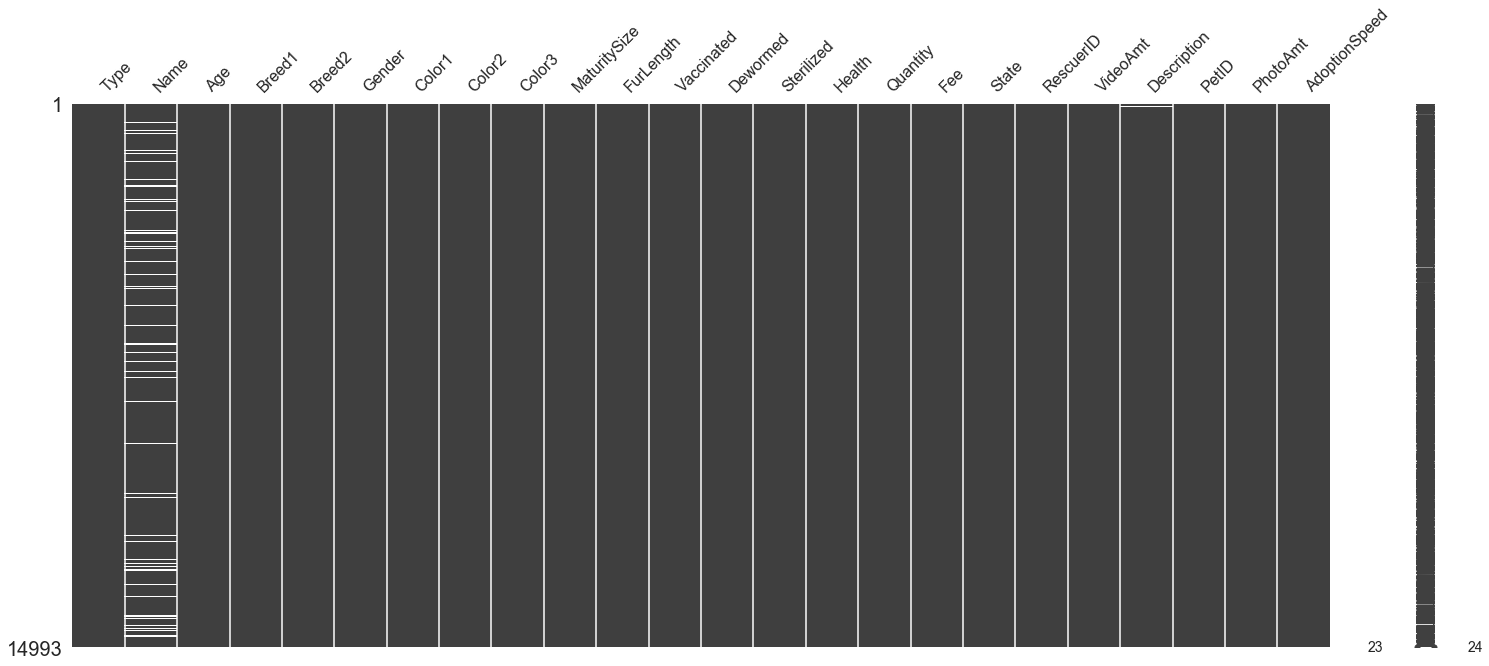

In [4]:
# check missing value
msno.matrix(df)
plt.show()

8.38% of the pets don't have names.

In [5]:
# check missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_percentage = (df.isnull().sum()/len(df)*100).round(2)
    missing_val = pd.concat([missing, missing_percentage], axis = 1)
    missing_val.columns = ['Missing Values', '% Missing']
    total_columns = df.shape[1]
    missing_columns = (df.isnull().sum() > 0).sum()
    print('Out of {} columns, {} columns have missing values'.format(total_columns, missing_columns))
    return missing_val

check_missing(df)

Out of 24 columns, 2 columns have missing values


,Missing Values,% Missing
Type,0,0.00
Name,1257,8.38
Age,0,0.00
Breed1,0,0.00
Breed2,0,0.00
Gender,0,0.00
Color1,0,0.00
Color2,0,0.00
Color3,0,0.00
MaturitySize,0,0.00


In [6]:
target = df[['AdoptionSpeed']]
id = df[['RescuerID', 'PetID']]
features = df.drop(['AdoptionSpeed', 'RescuerID', 'PetID'], axis=1)
num_cols = features.select_dtypes([np.number])
cat_cols = features.select_dtypes(exclude=[np.number])

In [7]:
num_cols.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000


### Target: AdoptionSpeed

The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
- 0 - Pet was adopted on the same day as it was listed.
- 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
- 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
- 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Very few pets were adopted on the same day as it was listed.

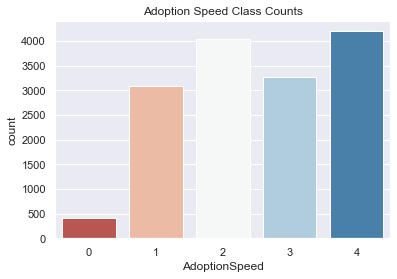

In [8]:
sns.countplot(df.AdoptionSpeed, palette='RdBu') 
plt.title('Adoption Speed Class Counts')
plt.show()

### Features

<b> Type

- 0 - Dog
- 1 - Cat

We have about 8,000 dogs and 7,000 cats in our dataset.

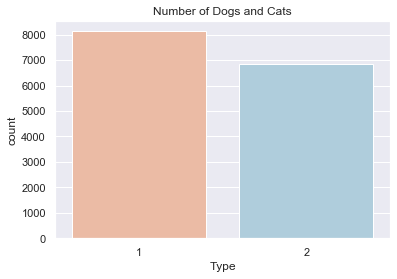

In [9]:
sns.countplot(df.Type, palette='RdBu') 
plt.title('Number of Dogs and Cats')
plt.show()

The average adoption speed of cats is faster than that of dogs.

In [10]:
def comparison_pct_plot(df, count_col, hue_col, title_name):
    g = sns.countplot(x=count_col, data=df, hue=hue_col)
    plt.title(title_name)
    

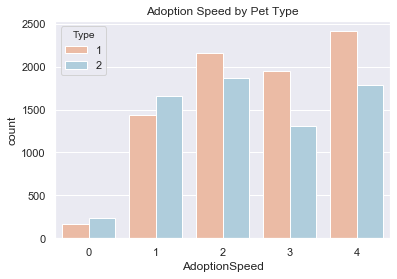

In [11]:
sns.countplot(df.AdoptionSpeed, hue=df.Type, palette='RdBu') 
plt.title('Adoption Speed by Pet Type')
plt.show()

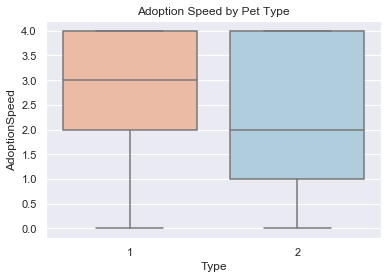

In [12]:
sns.boxplot(df.Type, df.AdoptionSpeed, palette='RdBu')
plt.title('Adoption Speed by Pet Type')
plt.show()

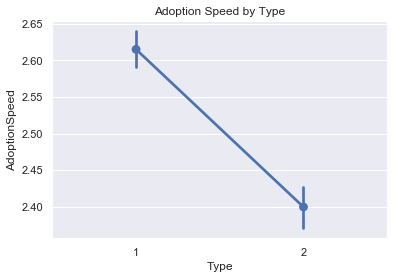

In [13]:
sns.pointplot(df.Type, df.AdoptionSpeed) 
plt.title('Adoption Speed by Type')
plt.show()

<b> Name

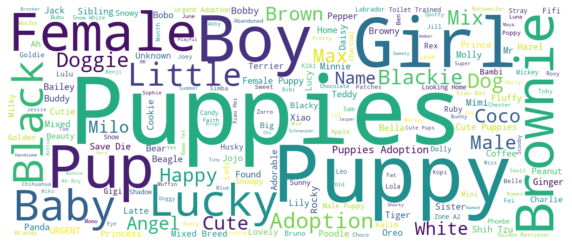

In [14]:
# generate a wordcloud image for dogs' names
dog_names = ' '.join(name for name in df.loc[df.Type==1, 'Name'] if type(name)!=float)
dog_name_wc = WordCloud(background_color='white', width=1200, height=500).generate(dog_names)

plt.figure(figsize=(10,8))
plt.imshow(dog_name_wc, interpolation='bilinear') 
_ = plt.axis('off')
plt.show()

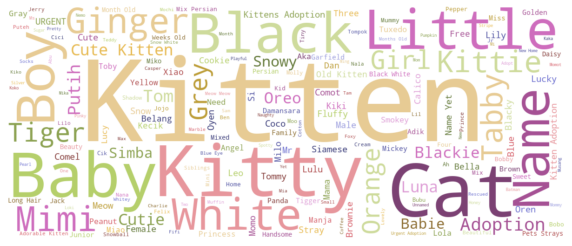

In [15]:
# generate a wordcloud image for cats' names
cat_names = ' '.join(name for name in df.loc[df.Type==2, 'Name'] if type(name)!=float)
cat_name_wc = WordCloud(background_color='white', width=1200, height=500, colormap='tab20b').generate(cat_names)

plt.figure(figsize=(10,8))
plt.imshow(cat_name_wc, interpolation='bilinear') 
_ = plt.axis('off')
plt.show()

<b> Age

The distribution plot is right skewed. Most of the pets are young.

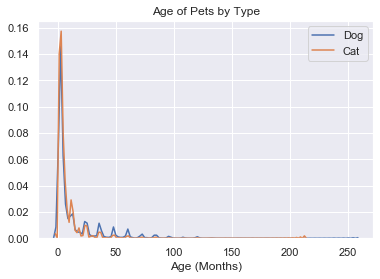

In [16]:
sns.kdeplot(df.loc[df.Type==1, 'Age'], label='Dog')
sns.kdeplot(df.loc[df.Type==2, 'Age'], label='Cat')
plt.title('Age of Pets by Type')
plt.xlabel('Age (Months)')
plt.legend()
plt.show()

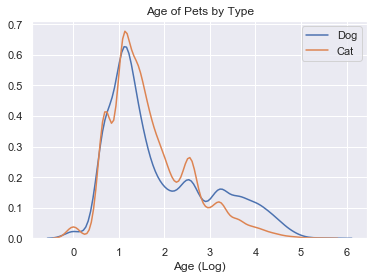

In [17]:
sns.kdeplot(np.log(df.loc[df.Type==1, 'Age']+1), label='Dog')
sns.kdeplot(np.log(df.loc[df.Type==2, 'Age']+1), label='Cat')
plt.title('Age of Pets by Type')
plt.xlabel('Age (Log)')
plt.legend()
plt.show()

The average age of the dogs and the cats in this dataset is about the same.

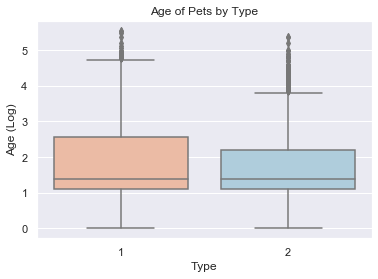

In [18]:
sns.boxplot(df.Type, np.log(df.Age+1), palette='RdBu')
plt.title('Age of Pets by Type')
plt.ylabel('Age (Log)')
plt.show()

Younger pets have a faster adoption speed.

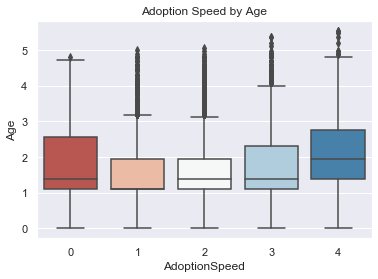

In [19]:
sns.boxplot(df.AdoptionSpeed, np.log(df.Age+1), palette='RdBu')
plt.title('Adoption Speed by Age')
plt.show()

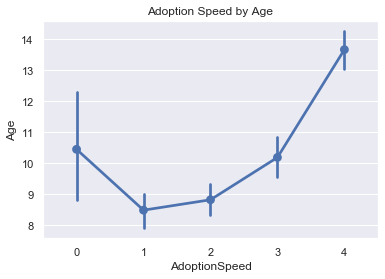

In [20]:
sns.pointplot(df.AdoptionSpeed, df.Age) 
plt.title('Adoption Speed by Age')
plt.show()

<b> Breed

- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

In [21]:
breed

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita
...,...,...,...
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van


If Breed2's value is 0, it indicates that the pet is pure breed.

In [22]:
df[['Breed1', 'Breed2']].head()

,Breed1,Breed2
0,299,0
1,265,0
2,307,0
3,307,0
4,307,0


In [23]:
# create a feature for pure breed
df['PureBreed'] = df.Breed2.apply(lambda x: 1 if x==0 else 0)

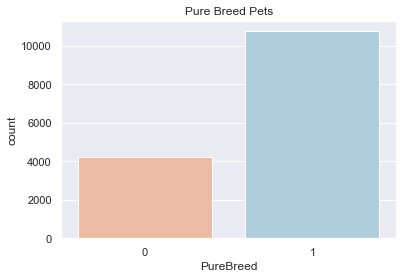

In [24]:
sns.countplot(df.PureBreed, palette='RdBu')
plt.title('Pure Breed Pets')
plt.show()

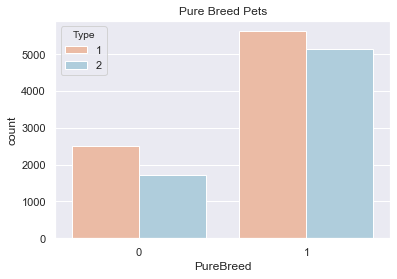

In [25]:
sns.countplot(df.PureBreed, hue=df.Type, palette='RdBu')
plt.title('Pure Breed Pets')
plt.show()

In [26]:
pure_breed = df.PureBreed.sum()/df.shape[0]*100
print('{}% of the pets are pure breed.'.format(round(pure_breed, 2)))

71.78% of the pets are pure breed.


Pure breed pets are preferred.

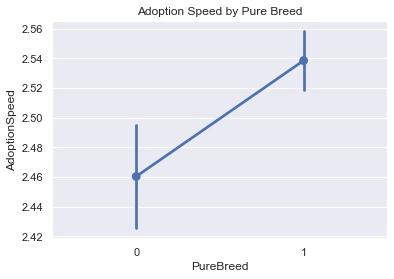

In [27]:
sns.pointplot(df.PureBreed, df.AdoptionSpeed) 
plt.title('Adoption Speed by Pure Breed')
plt.show()

<b> Gender

Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

In this dataset, we have more females pets than male pets. But male pets were adopted faster.

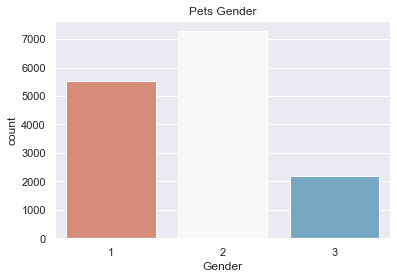

In [28]:
sns.countplot(df.Gender, palette='RdBu') 
plt.title('Pets Gender')
plt.show()

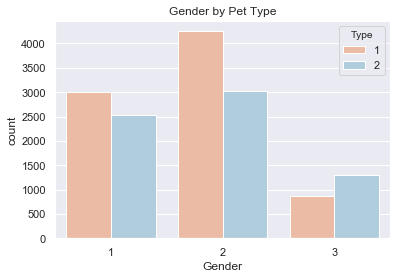

In [29]:
sns.countplot(df.Gender, hue=df.Type, palette='RdBu') 
plt.title('Gender by Pet Type')
plt.show()

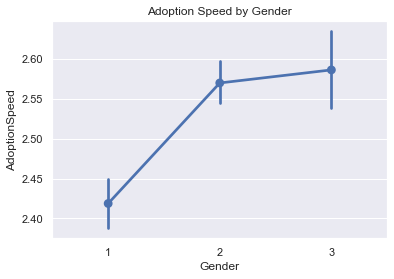

In [30]:
sns.pointplot(df.Gender, df.AdoptionSpeed) 
plt.title('Adoption Speed by Gender')
plt.show()

<b> Color

In [31]:
color

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


In [32]:
color_df = df[['Color1', 'Color2', 'Color3']]
color_df.head()

,Color1,Color2,Color3
0,1,7,0
1,1,2,0
2,2,7,0
3,1,2,0
4,1,0,0


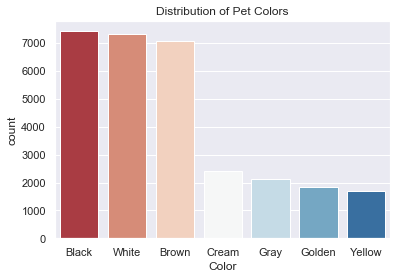

In [33]:
color_values = list(itertools.chain(*color_df.values.tolist()))
color_values = pd.DataFrame(filter(lambda x: x!=0, color_values), columns=['Color'])
color_values = color_values.merge(color, left_on='Color', right_on='ColorID')

sns.countplot(color_values.ColorName, palette='RdBu') 
plt.xlabel('Color')
plt.title('Distribution of Pet Colors')
plt.show()

In [34]:
# check each pet has how many colors
df['ColorNum'] = color_df.astype(bool).sum(axis=1)

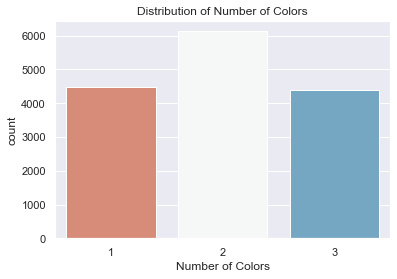

In [35]:
sns.countplot(df.ColorNum, palette='RdBu') 
plt.xlabel('Number of Colors')
plt.title('Distribution of Number of Colors')
plt.show()

Mixed-color pets were adopted faster.

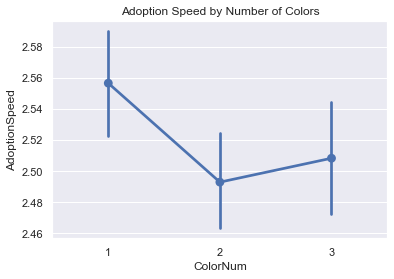

In [36]:
sns.pointplot(df.ColorNum, df.AdoptionSpeed) 
plt.title('Adoption Speed by Number of Colors')
plt.show()

<b> MaturitySize

Size at maturity (1 = small, 2 = medium, 3 = large, 4 = extra large, 0 = not specified)

Most pets are medium size.

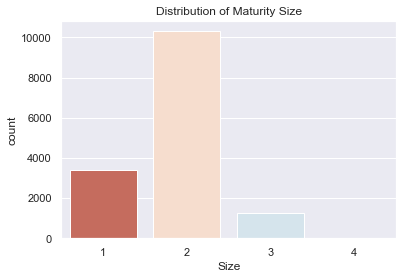

In [37]:
sns.countplot(df.MaturitySize, palette='RdBu') 
plt.xlabel('Size')
plt.title('Distribution of Maturity Size')
plt.show()

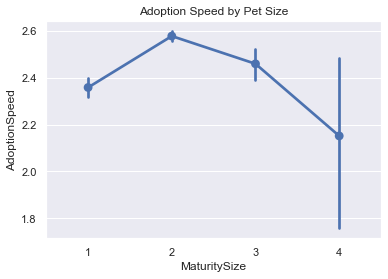

In [38]:
sns.pointplot(df.MaturitySize, df.AdoptionSpeed) 
plt.title('Adoption Speed by Pet Size')
plt.show()

<b> FurLength

Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

There are more pets with short fur in the datset. But people tend to prefer long fur pets.

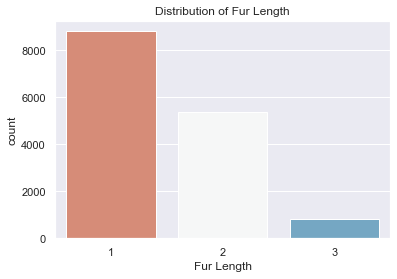

In [39]:
sns.countplot(df.FurLength, palette='RdBu') 
plt.xlabel('Fur Length')
plt.title('Distribution of Fur Length')
plt.show()

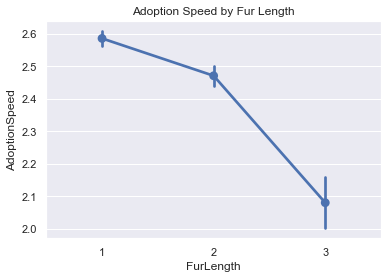

In [40]:
sns.pointplot(df.FurLength, df.AdoptionSpeed) 
plt.title('Adoption Speed by Fur Length')
plt.show()

<b> Vaccinated

Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

A combination core vaccine containing protection against parvo vi, and unvaccinated pets had a faster adoption speed. The third plot below provides the possible reason that people tend to adopt younger pets, and those pets were not old enough to be vaccinated.us, distemper virus, adenovirus and hepatitis should be given at 8, 10 and 12 weeks of age, and then repeated annually. In this dataset, we have more pets not vaccinated than vaccinated.

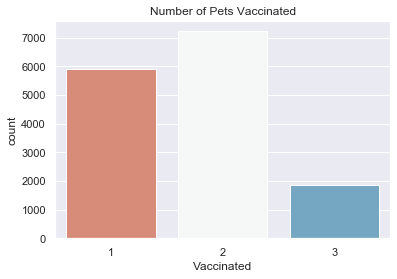

In [41]:
sns.countplot(df.Vaccinated, palette='RdBu') 
plt.title('Number of Pets Vaccinated')
plt.show()

Pets not vaccinated have a faster adoption speed. This is probably because they were adopted when they were small and haven't been vaccinated.

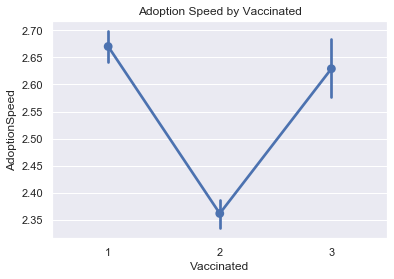

In [42]:
sns.pointplot(df.Vaccinated, df.AdoptionSpeed) 
plt.title('Adoption Speed by Vaccinated')
plt.show()

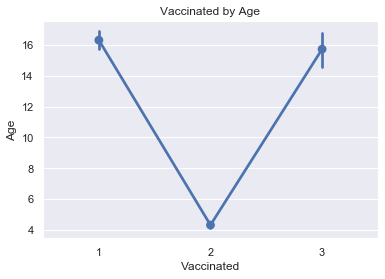

In [43]:
sns.pointplot(df.Vaccinated, df.Age) 
plt.title('Vaccinated by Age')
plt.show()

<b> Dewormed

Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Most pets have been dewormed, but they tend to have a slower adoption speed. The possible reason is the same as vaccination. Younger pets tend to be adopted faster and they are not old enough to be dewormed.

De-worming with an oral prescription de-wormer such as pyrantel palmoate or fenbendazole should take place every 2 weeks starting at 3 weeks of age. More pets were dewormed.

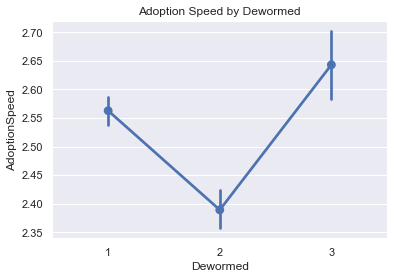

In [44]:
sns.pointplot(df.Dewormed, df.AdoptionSpeed) 
plt.title('Adoption Speed by Dewormed')
plt.show()

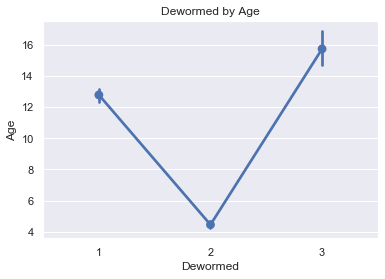

In [45]:
sns.pointplot(df.Dewormed, df.Age) 
plt.title('Dewormed by Age')
plt.show()

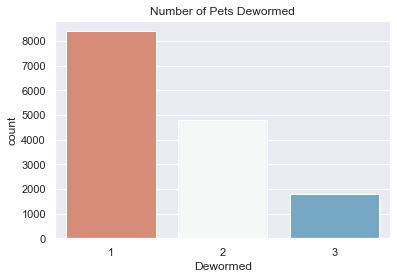

In [46]:
sns.countplot(df.Dewormed, palette='RdBu') 
plt.title('Number of Pets Dewormed')
plt.show()

<b> Sterilized

Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Most pets haven't been spayed/neutered, and they have a faster adoption speed.

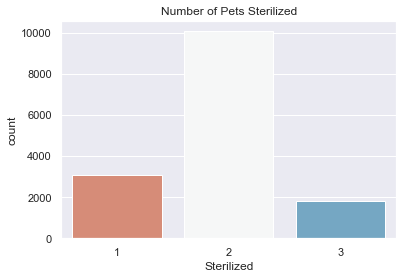

In [47]:
sns.countplot(df.Sterilized, palette='RdBu') 
plt.title('Number of Pets Sterilized')
plt.show()

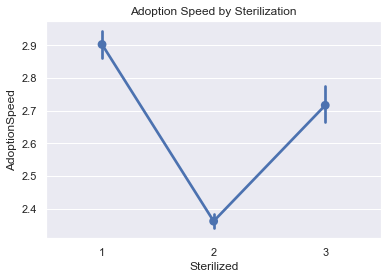

In [48]:
sns.pointplot(df.Sterilized, df.AdoptionSpeed) 
plt.title('Adoption Speed by Sterilization')
plt.show()

<b>Health

Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Most pets are healthy. 481 pets have minor injury and 34 pets have serious injury. Healthy pets tend to be adopted faster.

In [49]:
df.Health.value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

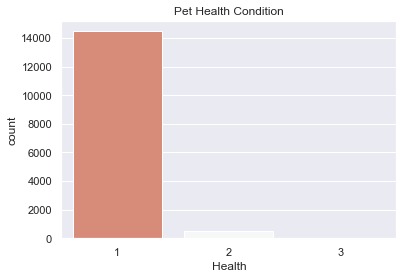

In [50]:
sns.countplot(df.Health, palette='RdBu') 
plt.title('Pet Health Condition')
plt.show()

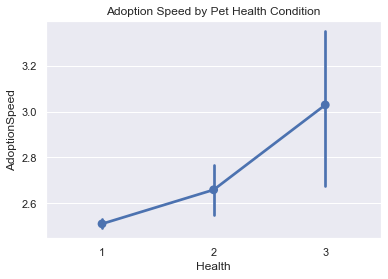

In [51]:
sns.pointplot(df.Health, df.AdoptionSpeed)
plt.title('Adoption Speed by Pet Health Condition')
plt.show()

<b> Quantity

Number of pets represented in profile.

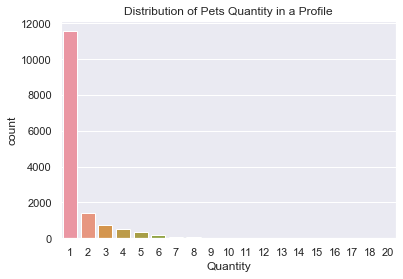

In [52]:
sns.countplot(df.Quantity) 
plt.title('Distribution of Pets Quantity in a Profile')
plt.show()

Profiles with fewer pets have a faster adoption speed.

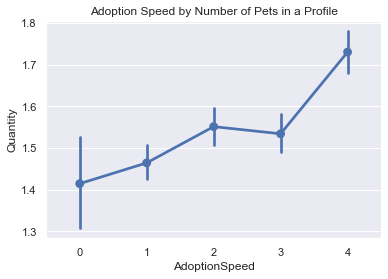

In [53]:
sns.pointplot(df.AdoptionSpeed, df.Quantity)
plt.title('Adoption Speed by Number of Pets in a Profile')
plt.show()

<b> Fee

Adoption fee (0 = Free)

Most pets are free to adopt

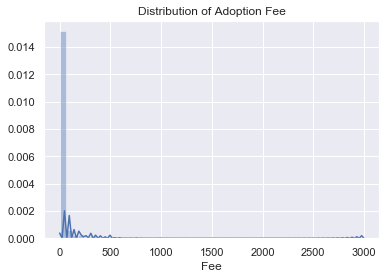

In [54]:
sns.distplot(df.Fee, kde_kws={'bw':0.1}) 
plt.title('Distribution of Adoption Fee')
plt.show()

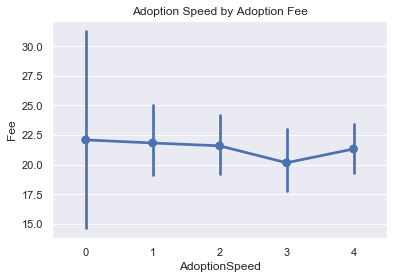

In [55]:
sns.pointplot(df.AdoptionSpeed, df.Fee)
plt.title('Adoption Speed by Adoption Fee')
plt.show()

<b> State

State location in Malaysia (Refer to StateLabels dictionary)

In [56]:
state

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


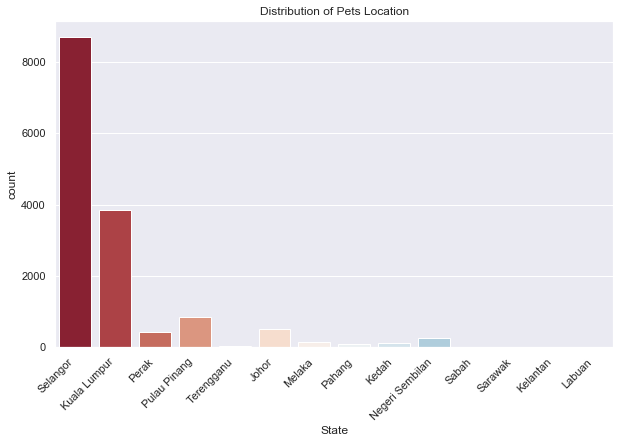

In [57]:
state_df = df[['State']].merge(state, left_on='State', right_on='StateID')

plt.figure(figsize=(10, 6))
g = sns.countplot(state_df.StateName, palette='RdBu') 
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('State')
plt.title('Distribution of Pets Location')
plt.show()

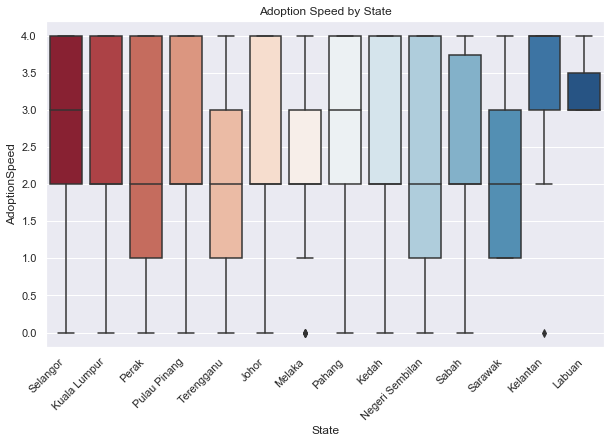

In [58]:
state_df = pd.concat([state_df, df[['AdoptionSpeed']]], axis=1)

plt.figure(figsize=(10, 6))
g = sns.boxplot(state_df.StateName, state_df.AdoptionSpeed, palette='RdBu') 
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('State')
plt.title('Adoption Speed by State')
plt.show()

<b> RescuerID

Unique hash ID of rescuer

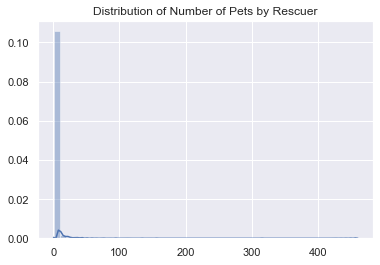

In [59]:
rescuer = df.groupby('RescuerID').size()

sns.distplot(rescuer)
plt.title('Distribution of Number of Pets by Rescuer')
plt.show()

In [60]:
# top rescuers
df.RescuerID.value_counts().head(20)

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
95481e953f8aed9ec3d16fc4509537e8    134
b770bac0ca797cf1433c48a35d30c4cb    111
a042471e0f43f2cf707104a1a138a7df     95
fd970cc91d06d82eebf046340137b272     93
7ed6d84e2e6879245e55447aee39c328     85
e62135526c27156b8479420aad166317     77
438a9bdce8ef4d5948fc40e422d34d0d     75
8b6c5cd067ada5f54ca5ffc7f7b5d896     74
cccb18b8f8b81862f9a1ebc65d651d22     65
001e42763024f9d4abe31e79472b1827     61
530f57b53cb3199e1d5e67733ddc0876     60
3b074cadd2350de62dca7056b9bab6f4     59
db784cbcf321e1d8856b312638b94113     52
3223e1c4cb2bef48823ee5c604b9aa04     52
9238e4f44c71a75282e62f7136c6b240     50
Name: RescuerID, dtype: int64

<b> VideoAmt

Total uploaded videos for this pet.

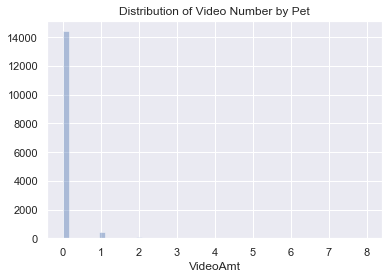

In [61]:
sns.distplot(df.VideoAmt, kde=False) 
plt.title('Distribution of Video Number by Pet') 
plt.show()

In [62]:
df.groupby('AdoptionSpeed')[['VideoAmt']].mean()

,VideoAmt
AdoptionSpeed,
0,0.060976
1,0.044984
2,0.063413
3,0.072722
4,0.046223


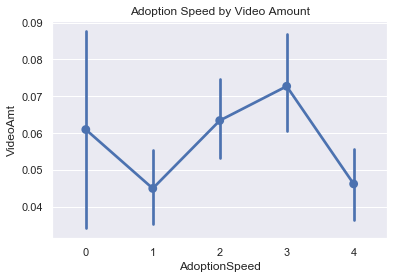

In [63]:
sns.pointplot(df.AdoptionSpeed, df.VideoAmt)
plt.title('Adoption Speed by Video Amount')
plt.show()

<b> PhotoAmt

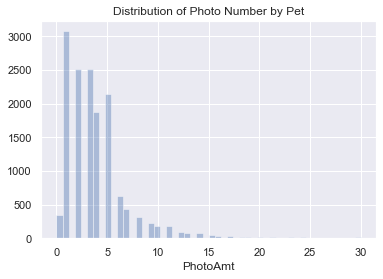

In [64]:
sns.distplot(df.PhotoAmt, kde=False) 
plt.title('Distribution of Photo Number by Pet') 
plt.show()

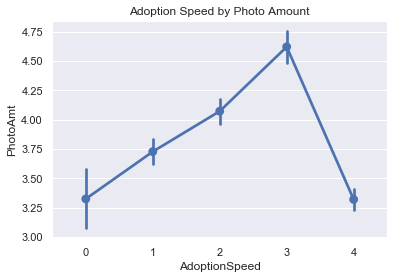

In [65]:
sns.pointplot(df.AdoptionSpeed, df.PhotoAmt)
plt.title('Adoption Speed by Photo Amount')
plt.show()

Total uploaded photos for this pet.

<b> Description

Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [82]:
df.Description.head(20)

0     Nibble is a 3+ month old ball of cuteness. He ...
1     I just found it alone yesterday near my apartm...
2     Their pregnant mother was dumped by her irresp...
3     Good guard dog, very alert, active, obedience ...
4     This handsome yet cute boy is up for adoption....
5     This is a stray kitten that came to my house. ...
6     anyone within the area of ipoh or taiping who ...
7     Siu Pak just give birth on 13/6/10 to 6puppies...
8     healthy and active, feisty kitten found in nei...
9     Very manja and gentle stray cat found, we woul...
10    For serious adopter, please do sms or call for...
11    Kali is a super playful kitten who is on the g...
12    Peanut was an abused puppy until he was rescue...
13    Hi Pet Lovers! This is my first posting and I ...
14    Lost Dog Found (Bandar Menjalara, Kepong／Taman...
15    We moved out of our apartment to a landed home...
16              to be spayed on /12 adorable & friendly
17    shes active... she can obey wht command th

In [66]:
df.Description.isnull().sum()

12

In [67]:
df.Description.fillna('', inplace = True)

In [114]:
# detect language
def detect_lan(text):
    try:
        language = detect(text)
    except:
        language = 'error'
    return language
        
df['DescLang'] = df.Description.apply(lambda x: detect_lan(x))

In [116]:
df.loc[df.DescLang=='error', ['Description', 'DescLang']]

,Description,DescLang
96,,error
436,-,error
605,,error
1098,,error
1522,.,error
1569,-,error
1601,0,error
2109,,error
2514,-,error
4218,,error


In [117]:
df.DescLang.value_counts()

en       14128
id         458
da         105
de          60
zh-cn       34
error       27
ro          24
no          24
es          14
tl          12
fr          11
af          11
so           9
nl           8
ko           8
cy           8
fi           7
hr           6
ca           6
sv           5
sl           4
zh-tw        4
sk           4
et           4
vi           3
it           3
pt           2
tr           2
sw           1
hu           1
Name: DescLang, dtype: int64

In [129]:
# translate all to English
not_en = df.loc[(df.DescLang!='en') & (df.DescLang!='error'), ['PetID', 'Description']]

def trans_desc(text):
    translator = Translator()
    translated = translator.translate(text)
    result = translated.text
    return result

not_en['TransDesc'] = not_en.Description.apply(lambda x: trans_desc(x))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

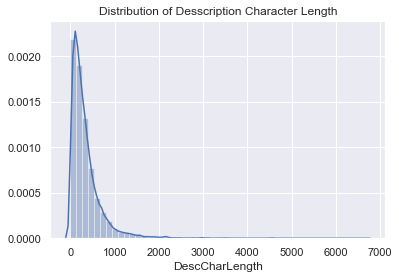

In [68]:
# description character length
df['DescCharLength'] = df.Description.apply(lambda x: len(x))

sns.distplot(df.DescCharLength)
plt.title('Distribution of Desscription Character Length')
plt.show()

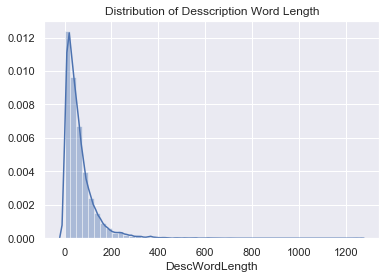

In [69]:
# description word length
df['DescWordLength'] = df.Description.apply(lambda x: len(x.split()))

sns.distplot(df.DescWordLength)
plt.title('Distribution of Desscription Word Length')
plt.show()

In [132]:
# only keep word characters and whitespaces
desc1 = df.Description.str.replace('[^\w\s]', '', flags=re.UNICODE)

# remove numbers
desc2 = desc1.str.replace('\d+', '')

# convert to lower case
desc3 = desc2.str.lower()

# remove leading and ending spaces
desc4 = desc3.str.strip()

In [133]:
# sentiment analysis
def nltk_sentiment(text):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(text)
    return score

sentiment = desc4.apply(lambda x: nltk_sentiment(x))

In [137]:
df['DescNeg'] = sentiment.apply(lambda x: x['neg'])
df['DescNeu'] = sentiment.apply(lambda x: x['neu'])
df['DescPos'] = sentiment.apply(lambda x: x['pos'])
df['DescCompound'] = sentiment.apply(lambda x: x['compound'])
df['DescSentiment'] = df.DescCompound.apply(lambda x: 'pos' if x>=0.05 else ('neg' if x <=-0.05 else 'neu'))

In [ ]:
# # tokenize
# stop_words = set(stopwords.words('english')) 
# tokenizer = word_tokenize()
# desc_tokens = desc4.apply(lambda x: tokenizer.tokenize(x))
# filtered_tokens = desc_tokens.apply(lambda x: [w for w in x if not w in stop_words])

In [ ]:
# # stemming
# stemmer = PorterStemmer()
# desc_stem = filtered_tokens.apply(lambda x: [stemmer.stem(w) for w in x])

In [ ]:
# # lemmatization
# lemmatizer = WordNetLemmatizer()
# desc_lemma = desc_stem.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [138]:
# count vectorizer
# tf_vectorizer = CountVectorizer(strip_accents='unicode',
#                                 stop_words='english',
#                                 lowercase=True,
#                                 token_pattern=r'\b[a-zA-Z]{3,}\b',
#                                 max_df=0.5, 
#                                 min_df=10)
# dtm_tf = tf_vectorizer.fit_transform(desc4)
# print(dtm_tf.shape)

(14993, 3618)


In [145]:
# dtm_tf_df = pd.DataFrame(dtm_tf.todense(), columns=tf_vectorizer.get_feature_names())
# s = dtm_tf_df.sum().sort_values(ascending = False)
# common_words = s[:100].index
# common_words

Index(['home', 'dog', 'adoption', 'cat', 'good', 'adopt', 'old', 'contact',
       'interested', 'looking', 'playful', 'love', 'loving', 'kitten', 'care',
       'puppy', 'cats', 'healthy', 'owner', 'rescued', 'like', 'active',
       'house', 'new', 'months', 'kittens', 'friendly', 'dogs', 'food', 'cute',
       'puppies', 'time', 'adopter', 'loves', 'little', 'family', 'need',
       'female', 'just', 'adopted', 'male', 'mother', 'trained', 'adorable',
       'vet', 'long', 'people', 'pls', 'help', 'pet', 'hope', 'shes',
       'forever', 'really', 'play', 'litter', 'black', 'lovely', 'sweet',
       'month', 'dewormed', 'stray', 'white', 'area', 'dont', 'weeks', 'thank',
       'needs', 'currently', 'vaccinated', 'vaccination', 'want', 'adopters',
       'hes', 'breed', 'girl', 'fee', 'age', 'free', 'siblings', 'abandoned',
       'boy', 'know', 'spayed', 'eyes', 'provide', 'beautiful', 'attention',
       'able', 'email', 'whatsapp', 'fur', 'birth', 'let', 'thanks', 'willing',
    

In [150]:
# tfidf vectorizer
# customized_stopwords = stop_words.union(set(common_words))

tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                    stop_words='english',
                                    lowercase=True,
                                    token_pattern=r'\b[a-zA-Z]{3,}\b',
                                    max_df=0.5, 
                                    min_df=10)
dtm_tfidf = tfidf_vectorizer.fit_transform(desc4)
print(dtm_tfidf.shape)

(14993, 3618)


In [151]:
# lda
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=SEED)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [152]:
# topic modeling
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.088866 -0.030932       1        1  41.197293
1     -0.079742  0.034500       2        1  26.284634
3     -0.102808 -0.123892       3        1  15.950398
4     -0.042373  0.141764       4        1   8.986967
2      0.313789 -0.021440       5        1   7.580708, topic_info=          Term        Freq       Total Category  logprob  loglift
56    adoption  700.000000  700.000000  Default  30.0000  30.0000
25      active  317.000000  317.000000  Default  29.0000  29.0000
2380   playful  349.000000  349.000000  Default  28.0000  28.0000
1206  friendly  296.000000  296.000000  Default  27.0000  27.0000
776       cute  317.000000  317.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
915        dog   79.885443  451.216990   Topic5  -4.0635   0.8482
1918     manja   30.317986  127.452768   Topic5  -5.0324   1.1436
518        cat   33.379931  402.076678   Topic5  -4.9362   0.0909
1687    kitten   22.821440  307.760192   Topic5  -5.3164  -0.0221
1688   kittens   19.470537  258.521592   Topic5  -5.4752  -0.0065

[370 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.927281    abandon
0         2  0.084298    abandon
1         1  0.681977  abandoned
1         2  0.127871  abandoned
1         3  0.153445  abandoned
...     ...       ...        ...
3593      5  0.986128       yang
3602      1  0.053762     yellow
3602      2  0.913946     yellow
3605      1  0.910725  yesterday
3605      2  0.060715  yesterday

[722 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

Number of components = 10 and explained variance = 0.08720314787014377
Number of components = 20 and explained variance = 0.13433962764961072
Number of components = 50 and explained variance = 0.2255347187253809
Number of components = 100 and explained variance = 0.32269238215703766
Number of components = 500 and explained variance = 0.6354693688197812
Number of components = 1000 and explained variance = 0.7932678172455302
Number of components = 1500 and explained variance = 0.881168082952767


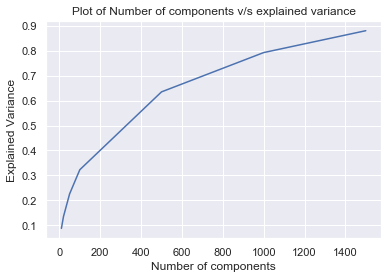

In [153]:
# find the optimal number of components for Truncated SVD
n_comp = [10,20,50,100,500,1000,1500]
explained = []
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(dtm_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print('Number of components = %r and explained variance = %r'%(x,svd.explained_variance_ratio_.sum()))

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.title('Plot of Number of components v/s explained variance')
plt.show()

In [154]:
# dimension reduction
svd = TruncatedSVD(n_components=1500)
tfidf = svd.fit_transform(dtm_tfidf)
tfidf_df = pd.DataFrame(tfidf)

In [159]:
tfidf_df.to_csv('desc_tfidf.csv', index=False)

In [156]:
df.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,PureBreed,ColorNum,DescCharLength,DescWordLength,DescLang,DescNeg,DescNeu,DescPos,DescCompound,DescSentiment
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,1,2,359,69,en,0.000,0.742,0.258,0.9552,pos
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,1,2,118,23,en,0.149,0.723,0.129,0.1280,pos
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,1,2,393,69,en,0.095,0.706,0.200,0.7650,pos
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,1,2,146,25,en,0.000,0.490,0.510,0.9494,pos
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,1,1,390,81,en,0.000,0.635,0.365,0.9880,pos
5,2,NaN,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2,1,2,87,18,en,0.000,1.000,0.000,0.0000,neu
6,2,BULAT,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1,0,1,400,78,en,0.000,0.814,0.186,0.9116,pos
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3,1,3,109,20,en,0.000,0.800,0.200,0.4588,pos
8,2,NaN,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1,1,1,79,13,en,0.113,0.576,0.311,0.5327,pos
9,2,Kitty,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4,1,2,232,45,en,0.000,0.751,0.249,0.8916,pos


In [160]:
df.to_csv('processes_df1.csv', index=False)